In [110]:
# RNN Encoder-Decoder

In [111]:
import numpy as np

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [114]:
import tensorflow as tf

In [115]:
np.random.seed(0)
tf.set_random_seed(1234)

In [116]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [117]:
# Preparing data

In [118]:
def number(digits=3):
    number = ''
    for i in range(np.random.randint(1, digits+1)):
        number += np.random.choice(list('0123456789'))
    return number

In [119]:
def padding(chars, maxlen):
    return chars + ' ' * (maxlen - len(chars))

In [120]:
N = 20000
digits = 3
dim_seq_input = digits * 2 + 1
dim_seq_output = digits + 1

In [121]:
added = set()
questions = []
answers = []

In [122]:
while len(questions) < N:
    a, b = number(digits), number(digits)
    
    pair = tuple(sorted((a, b)))
    if pair in added:
        continue
    
    question = '{0}+{1}'.format(a, b)
    question = padding(question, dim_seq_input)
    
    answer = str(int(a) +int(b))
    answer = padding(answer, dim_seq_output)
    
    added.add(pair)
    questions.append(question)
    answers.append(answer)

In [123]:
chars = '0123456789+ '
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [124]:
dim_input = len(chars)
dim_output = len(chars)

In [125]:
X = np.zeros((N, dim_seq_input, len(chars)), dtype=np.integer)
Y = np.zeros((N, dim_seq_output, len(chars)), dtype=np.integer)

In [126]:
for i in range(N):
    for j, char in enumerate(questions[i]):
        X[i, j, char_indices[char]] = 1
    for j, char in enumerate(answers[i]):
        Y[i, j, char_indices[char]] = 1

In [127]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1)

In [128]:
# Building a model

In [129]:
class RNN_Encoder_Decoder(object):
    def __init__(self, graph, dim_seq_input, dim_input, dim_seq_output, dim_output, dim_hiddens):
        self.graph = graph # Global graph
        
        self.dim_seq_input = dim_seq_input # Length of input sequence
        self.dim_input = dim_input # Length of each input data
        
        self.dim_seq_output = dim_seq_output  # Length of output sequence
        self.dim_output = dim_output # Length of each output data
        
        self.dim_hiddens = dim_hiddens # Length of hidden layer

        with self.graph.as_default():
            self._x = tf.placeholder(tf.float32, shape=[None, self.dim_seq_input, self.dim_input], name='x')
            self._t = tf.placeholder(tf.float32, shape=[None, self.dim_seq_output, self.dim_output], name='t')
            self._batch_size = tf.placeholder(tf.int32, name='batch_size')

        self._train_step = None

        self._y = None
        self._loss= None
        self._acc = None
        
        self._sess = None
        
    def inference_training(self, x, y, batch_size):
        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.01)
            return tf.Variable(initial, name='V')

        def bias_variable(shape):
            initial = tf.zeros(shape, dtype=tf.float32)
            return tf.Variable(initial, name='c')
        
        with tf.name_scope('Training'):
            # Encoder
            self._encoder = tf.contrib.rnn.BasicLSTMCell(self.dim_hiddens[0], forget_bias=1.0)

            encoder_state = self._encoder.zero_state(tf.cast(batch_size, tf.int32), tf.float32)

            with tf.name_scope('Encoder_LSTM_1'):
                with tf.variable_scope('Encoder_LSTM_1'):
                    for i in range(self.dim_seq_input):
                        if i > 0:
                            tf.get_variable_scope().reuse_variables()

                        encoder_output, encoder_state = self._encoder(x[:, i, :], encoder_state)

            # Decoder
            with tf.name_scope('Decoder_LSTM_1'):
                self._decoder = tf.contrib.rnn.BasicLSTMCell(self.dim_hiddens[0], forget_bias=1.0)

                decoder_outputs = [encoder_output]
                decoder_state = encoder_state

                with tf.variable_scope('Decoder_LSTM_1'):
                    for i in range(1, self.dim_seq_output):
                        if i > 1:
                            tf.get_variable_scope().reuse_variables()

                        decoder_output, decoder_state = self._decoder(y[:, i-1, :], decoder_state)
                        decoder_outputs.append(decoder_output)

            with tf.name_scope('Output'):
                # Node Instance
                self._V = weight_variable([self.dim_hiddens[0], self.dim_output])
                self._c = bias_variable([self.dim_output])

                decoder_output = tf.reshape(tf.concat(decoder_outputs, axis=1),
                                            [-1, self.dim_seq_output, self.dim_hiddens[0]])

                return tf.nn.softmax(tf.einsum('ijk,kl->ijl', decoder_output, self._V) + self._c)

    def inference_validation(self, x, batch_size): 
        with tf.name_scope('Validation'):
            # Encoder
            encoder_state = self._encoder.zero_state(tf.cast(batch_size, tf.int32), tf.float32)

            with tf.name_scope('Encoder_LSTM_1'):
                with tf.variable_scope('Encoder_LSTM_1'):
                    tf.get_variable_scope().reuse_variables()
                    for i in range(self.dim_seq_input):
                        encoder_output, encoder_state = self._encoder(x[:, i, :], encoder_state)

            # Decoder & Output
            decoder_output = encoder_output
            decoder_state = encoder_state
            
            outputs = []

            for i in range(1, self.dim_seq_output):
                with tf.name_scope('Output'):
                    output = tf.nn.softmax(tf.matmul(decoder_output, self._V) + self._c)
                    outputs.append(output)

                with tf.name_scope('Decoder_LSTM_1'):
                    with tf.variable_scope('Decoder_LSTM_1'):
                        tf.get_variable_scope().reuse_variables()

                        input = tf.one_hot(tf.argmax(output, -1), depth=self.dim_output)
                        decoder_output, decoder_state = self._decoder(input, decoder_state)

            with tf.name_scope('Output'):
                outputs.append(tf.nn.softmax(tf.matmul(decoder_output, self._V) + self._c))
                return tf.reshape(tf.concat(outputs, axis=1), [-1, self.dim_seq_output, self.dim_output])
        
    def loss(self, y, t):
        with tf.name_scope('Loss'):
            cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(tf.clip_by_value(y, 1e-10, 1.0)),
                                                          reduction_indices=[1]))
        
        return cross_entropy
    
    def training(self, loss):
        with tf.name_scope('Train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
            train_step = optimizer.minimize(loss)
        
        return train_step
    
    def accuracy(self, y, t):
        with tf.name_scope('Accuracy'):
            correct_prediction = tf.equal(tf.argmax(y, -1), tf.argmax(t, -1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
        return accuracy
 
    def output(self, seq_input, seq_output):
        prediction = self._y.eval(session=self._sess,
                                  feed_dict={
                                      self._x: seq_input,
                                      self._batch_size: 1
                                  })
        
        question = seq_input.argmax(axis=-1)
        answer = seq_output.argmax(axis=-1)
        prediction = prediction.argmax(axis=-1)
        
        q = ''.join(indices_char[i] for i in question[0])
        a = ''.join(indices_char[i] for i in answer[0])
        p = ''.join(indices_char[i] for i in prediction[0])

        print('-'*10)
        print('Q: {0}'.format(q))
        print('A: {0}'.format(p))
        print('T/F: {0}'.format((lambda x: 'T' if x==a else 'F')(p)))

    def compile(self):
        with self.graph.as_default():
            y = self.inference_training(self._x, self._t, self._batch_size)
            loss = self.loss(y, self._t)
            self._train_step = self.training(loss)
            
            self._y = self.inference_validation(self._x, self._batch_size)
            self._loss= self.loss(self._y, self._t)
            self._acc = self.accuracy(self._y, self._t)
        
    def fit(self, X_train, Y_train, X_validation, Y_validation, epochs=500, batch_size=10, verbose=1):
        N_train = len(X_train)
        n_batches = N_train // batch_size

        history = {
            'val_acc': [],
            'val_loss': []
        }
        
        with self.graph.as_default():
            init = tf.global_variables_initializer()
            sess = tf.Session()
            sess.run(init)

            self._sess = sess
            
            for epoch in range(epochs):
                X_, Y_ = shuffle(X_train, Y_train)

                for i in range(n_batches):
                    start = i * batch_size
                    end = start + batch_size

                    sess.run(
                        self._train_step,
                        feed_dict={
                            self._x: X_[start:end],
                            self._t: Y_[start:end],
                            self._batch_size: batch_size
                        })

                val_loss_ = self._loss.eval(
                                session=sess,
                                feed_dict={
                                    self._x: X_validation,
                                    self._t: Y_validation,
                                    self._batch_size: len(X_validation)
                                })
                
                val_acc_ = self._acc.eval(
                                    session=sess,
                                    feed_dict={
                                        self._x: X_validation,
                                        self._t: Y_validation,
                                        self._batch_size: len(X_validation)
                                    })

                history['val_loss'].append(val_loss_)
                history['val_acc'].append(val_acc_)

                if verbose:
                    print("epoch: {0} / val_loss: {1} / val_acc: {2}".format(epoch, val_loss_, val_acc_))
                    
                    for i in range(10):
                        index = np.random.randint(0, len(X_validation))
                        question = X_validation[np.array([index])]
                        answer = Y_validation[np.array([index])]
                        
                        self.output(question, answer)
                        
            return history
    
    def show_graph(self):
        with self.graph.as_default():
            show_graph(tf.Session().graph_def)

In [130]:
model = RNN_Encoder_Decoder(tf.Graph(),
                            dim_seq_input=dim_seq_input,
                            dim_input=dim_input,
                            dim_seq_output=dim_seq_output,
                            dim_output=dim_output,
                            dim_hiddens=[128])

In [131]:
model.compile()

In [132]:
model.show_graph()

In [133]:
history = model.fit(X_train,
                    Y_train,
                    X_validation,
                    Y_validation,
                    epochs=200,
                    batch_size=200)

epoch: 0 / val_loss: 0.620207667350769 / val_acc: 0.3543750047683716
----------
Q: 1+116  
A: 11  
T/F: F
----------
Q: 964+806
A: 1110
T/F: F
----------
Q: 9+039  
A: 112 
T/F: F
----------
Q: 561+8  
A: 112 
T/F: F
----------
Q: 56+860 
A: 116 
T/F: F
----------
Q: 851+82 
A: 112 
T/F: F
----------
Q: 52+773 
A: 112 
T/F: F
----------
Q: 5+20   
A: 11  
T/F: F
----------
Q: 3+649  
A: 112 
T/F: F
----------
Q: 02+60  
A: 11  
T/F: F
epoch: 1 / val_loss: 0.6626909971237183 / val_acc: 0.3125
----------
Q: 389+295
A: 1000
T/F: F
----------
Q: 553+4  
A: 102 
T/F: F
----------
Q: 708+31 
A: 102 
T/F: F
----------
Q: 3+353  
A: 102 
T/F: F
----------
Q: 319+61 
A: 100 
T/F: F
----------
Q: 06+268 
A: 100 
T/F: F
----------
Q: 130+02 
A: 102 
T/F: F
----------
Q: 71+438 
A: 100 
T/F: F
----------
Q: 542+26 
A: 100 
T/F: F
----------
Q: 226+916
A: 1000
T/F: F
epoch: 2 / val_loss: 0.6838724613189697 / val_acc: 0.2955000102519989
----------
Q: 510+8  
A: 100 
T/F: F
----------
Q: 1+77   
A: 1

epoch: 19 / val_loss: 0.46914052963256836 / val_acc: 0.5182499885559082
----------
Q: 2+00   
A: 6   
T/F: F
----------
Q: 88+335 
A: 426 
T/F: F
----------
Q: 66+506 
A: 622 
T/F: F
----------
Q: 434+292
A: 455 
T/F: F
----------
Q: 617+408
A: 1108
T/F: F
----------
Q: 019+12 
A: 22  
T/F: F
----------
Q: 56+03  
A: 10  
T/F: F
----------
Q: 139+433
A: 456 
T/F: F
----------
Q: 978+042
A: 1002
T/F: F
----------
Q: 373+073
A: 370 
T/F: F
epoch: 20 / val_loss: 0.4646630883216858 / val_acc: 0.5258749723434448
----------
Q: 433+6  
A: 439 
T/F: T
----------
Q: 1+245  
A: 254 
T/F: F
----------
Q: 16+8   
A: 16  
T/F: F
----------
Q: 357+89 
A: 414 
T/F: F
----------
Q: 396+51 
A: 423 
T/F: F
----------
Q: 95+764 
A: 863 
T/F: F
----------
Q: 724+2  
A: 735 
T/F: F
----------
Q: 0+131  
A: 133 
T/F: F
----------
Q: 679+993
A: 1649
T/F: F
----------
Q: 155+923
A: 1137
T/F: F
epoch: 21 / val_loss: 0.44944438338279724 / val_acc: 0.5338749885559082
----------
Q: 82+430 
A: 528 
T/F: F
--------

epoch: 38 / val_loss: 0.25656643509864807 / val_acc: 0.7310000061988831
----------
Q: 400+5  
A: 405 
T/F: T
----------
Q: 679+993
A: 1691
T/F: F
----------
Q: 331+42 
A: 364 
T/F: F
----------
Q: 48+31  
A: 80  
T/F: F
----------
Q: 375+27 
A: 302 
T/F: F
----------
Q: 492+525
A: 966 
T/F: F
----------
Q: 95+13  
A: 108 
T/F: T
----------
Q: 48+61  
A: 109 
T/F: T
----------
Q: 11+989 
A: 999 
T/F: F
----------
Q: 2+958  
A: 961 
T/F: F
epoch: 39 / val_loss: 0.2466350942850113 / val_acc: 0.7403749823570251
----------
Q: 741+350
A: 1103
T/F: F
----------
Q: 11+977 
A: 988 
T/F: T
----------
Q: 396+51 
A: 467 
T/F: F
----------
Q: 68+838 
A: 816 
T/F: F
----------
Q: 5+887  
A: 892 
T/F: T
----------
Q: 111+4  
A: 115 
T/F: T
----------
Q: 38+86  
A: 124 
T/F: T
----------
Q: 15+871 
A: 876 
T/F: F
----------
Q: 008+729
A: 717 
T/F: F
----------
Q: 00+57  
A: 57  
T/F: T
epoch: 40 / val_loss: 0.24108879268169403 / val_acc: 0.746874988079071
----------
Q: 517+50 
A: 567 
T/F: T
---------

epoch: 57 / val_loss: 0.15841759741306305 / val_acc: 0.8535000085830688
----------
Q: 2+067  
A: 69  
T/F: T
----------
Q: 679+993
A: 1680
T/F: F
----------
Q: 245+876
A: 1121
T/F: T
----------
Q: 365+9  
A: 374 
T/F: T
----------
Q: 25+375 
A: 390 
T/F: F
----------
Q: 70+644 
A: 715 
T/F: F
----------
Q: 6+943  
A: 959 
T/F: F
----------
Q: 098+45 
A: 143 
T/F: T
----------
Q: 32+73  
A: 105 
T/F: T
----------
Q: 100+41 
A: 141 
T/F: T
epoch: 58 / val_loss: 0.15719319880008698 / val_acc: 0.8507500290870667
----------
Q: 464+6  
A: 460 
T/F: F
----------
Q: 2+364  
A: 366 
T/F: T
----------
Q: 531+689
A: 1110
T/F: F
----------
Q: 684+2  
A: 686 
T/F: T
----------
Q: 975+551
A: 1526
T/F: T
----------
Q: 8+251  
A: 259 
T/F: T
----------
Q: 8+540  
A: 548 
T/F: T
----------
Q: 2+213  
A: 215 
T/F: T
----------
Q: 672+40 
A: 613 
T/F: F
----------
Q: 48+68  
A: 116 
T/F: T
epoch: 59 / val_loss: 0.15367130935192108 / val_acc: 0.8537499904632568
----------
Q: 5+58   
A: 63  
T/F: T
-------

epoch: 76 / val_loss: 0.12432229518890381 / val_acc: 0.8888750076293945
----------
Q: 029+3  
A: 32  
T/F: T
----------
Q: 047+593
A: 640 
T/F: T
----------
Q: 287+2  
A: 299 
T/F: F
----------
Q: 781+154
A: 895 
T/F: F
----------
Q: 117+32 
A: 148 
T/F: F
----------
Q: 174+87 
A: 261 
T/F: T
----------
Q: 167+170
A: 217 
T/F: F
----------
Q: 5+006  
A: 11  
T/F: T
----------
Q: 793+02 
A: 795 
T/F: T
----------
Q: 735+854
A: 1699
T/F: F
epoch: 77 / val_loss: 0.125491663813591 / val_acc: 0.8916249871253967
----------
Q: 104+1  
A: 105 
T/F: T
----------
Q: 939+666
A: 1595
T/F: F
----------
Q: 76+37  
A: 113 
T/F: T
----------
Q: 124+35 
A: 169 
T/F: F
----------
Q: 978+042
A: 1030
T/F: F
----------
Q: 762+29 
A: 791 
T/F: T
----------
Q: 389+295
A: 774 
T/F: F
----------
Q: 411+40 
A: 421 
T/F: F
----------
Q: 942+216
A: 1277
T/F: F
----------
Q: 1+101  
A: 112 
T/F: F
epoch: 78 / val_loss: 0.12813855707645416 / val_acc: 0.887374997138977
----------
Q: 0+529  
A: 529 
T/F: T
----------

epoch: 95 / val_loss: 0.11572789400815964 / val_acc: 0.9047499895095825
----------
Q: 302+2  
A: 304 
T/F: T
----------
Q: 2+108  
A: 100 
T/F: F
----------
Q: 47+553 
A: 591 
T/F: F
----------
Q: 98+229 
A: 327 
T/F: T
----------
Q: 895+7  
A: 892 
T/F: F
----------
Q: 72+21  
A: 93  
T/F: T
----------
Q: 4+60   
A: 64  
T/F: T
----------
Q: 59+28  
A: 87  
T/F: T
----------
Q: 653+834
A: 1497
T/F: F
----------
Q: 05+98  
A: 103 
T/F: T
epoch: 96 / val_loss: 0.11254099756479263 / val_acc: 0.9068750143051147
----------
Q: 243+61 
A: 304 
T/F: T
----------
Q: 4+792  
A: 796 
T/F: T
----------
Q: 27+983 
A: 1010
T/F: T
----------
Q: 820+25 
A: 835 
T/F: F
----------
Q: 940+40 
A: 980 
T/F: T
----------
Q: 55+218 
A: 273 
T/F: T
----------
Q: 072+94 
A: 166 
T/F: T
----------
Q: 503+90 
A: 593 
T/F: T
----------
Q: 517+953
A: 1460
T/F: F
----------
Q: 238+563
A: 801 
T/F: T
epoch: 97 / val_loss: 0.11457493901252747 / val_acc: 0.9037500023841858
----------
Q: 03+232 
A: 235 
T/F: T
-------

epoch: 114 / val_loss: 0.10952844470739365 / val_acc: 0.9143750071525574
----------
Q: 993+510
A: 1512
T/F: F
----------
Q: 658+90 
A: 748 
T/F: T
----------
Q: 882+092
A: 974 
T/F: T
----------
Q: 491+16 
A: 507 
T/F: T
----------
Q: 0+294  
A: 294 
T/F: T
----------
Q: 11+180 
A: 191 
T/F: T
----------
Q: 2+542  
A: 544 
T/F: T
----------
Q: 144+9  
A: 153 
T/F: T
----------
Q: 114+05 
A: 129 
T/F: F
----------
Q: 776+10 
A: 786 
T/F: T
epoch: 115 / val_loss: 0.10947491228580475 / val_acc: 0.9122499823570251
----------
Q: 433+85 
A: 528 
T/F: F
----------
Q: 3+290  
A: 293 
T/F: T
----------
Q: 57+222 
A: 279 
T/F: T
----------
Q: 038+1  
A: 39  
T/F: T
----------
Q: 0+789  
A: 789 
T/F: T
----------
Q: 918+119
A: 1127
T/F: F
----------
Q: 651+529
A: 1171
T/F: F
----------
Q: 324+5  
A: 329 
T/F: T
----------
Q: 807+6  
A: 813 
T/F: T
----------
Q: 864+566
A: 1420
T/F: F
epoch: 116 / val_loss: 0.11758183687925339 / val_acc: 0.9097499847412109
----------
Q: 17+198 
A: 215 
T/F: T
----

epoch: 133 / val_loss: 0.105193592607975 / val_acc: 0.9191250205039978
----------
Q: 82+430 
A: 512 
T/F: T
----------
Q: 588+784
A: 1462
T/F: F
----------
Q: 79+183 
A: 262 
T/F: T
----------
Q: 484+03 
A: 487 
T/F: T
----------
Q: 589+3  
A: 592 
T/F: T
----------
Q: 797+13 
A: 800 
T/F: F
----------
Q: 29+198 
A: 227 
T/F: T
----------
Q: 2+420  
A: 422 
T/F: T
----------
Q: 663+571
A: 1214
T/F: F
----------
Q: 093+892
A: 985 
T/F: T
epoch: 134 / val_loss: 0.10865217447280884 / val_acc: 0.918749988079071
----------
Q: 895+41 
A: 936 
T/F: T
----------
Q: 179+614
A: 803 
T/F: F
----------
Q: 9+857  
A: 866 
T/F: T
----------
Q: 86+3   
A: 89  
T/F: T
----------
Q: 8+064  
A: 72  
T/F: T
----------
Q: 249+360
A: 609 
T/F: T
----------
Q: 20+67  
A: 87  
T/F: T
----------
Q: 845+31 
A: 876 
T/F: T
----------
Q: 5+58   
A: 63  
T/F: T
----------
Q: 842+35 
A: 877 
T/F: T
epoch: 135 / val_loss: 0.1101742833852768 / val_acc: 0.9176250100135803
----------
Q: 05+812 
A: 817 
T/F: T
--------

epoch: 152 / val_loss: 0.11061456054449081 / val_acc: 0.9192500114440918
----------
Q: 89+40  
A: 129 
T/F: T
----------
Q: 978+042
A: 1010
T/F: F
----------
Q: 345+991
A: 1356
T/F: F
----------
Q: 456+03 
A: 469 
T/F: F
----------
Q: 79+174 
A: 253 
T/F: T
----------
Q: 60+28  
A: 88  
T/F: T
----------
Q: 8+452  
A: 460 
T/F: T
----------
Q: 88+946 
A: 1044
T/F: F
----------
Q: 7+900  
A: 907 
T/F: T
----------
Q: 0+242  
A: 242 
T/F: T
epoch: 153 / val_loss: 0.10959678143262863 / val_acc: 0.922124981880188
----------
Q: 5+006  
A: 11  
T/F: T
----------
Q: 16+8   
A: 24  
T/F: T
----------
Q: 553+4  
A: 557 
T/F: T
----------
Q: 379+52 
A: 431 
T/F: T
----------
Q: 81+193 
A: 274 
T/F: T
----------
Q: 918+8  
A: 926 
T/F: T
----------
Q: 897+71 
A: 968 
T/F: T
----------
Q: 93+89  
A: 182 
T/F: T
----------
Q: 00+157 
A: 157 
T/F: T
----------
Q: 375+27 
A: 302 
T/F: F
epoch: 154 / val_loss: 0.1099981814622879 / val_acc: 0.9211249947547913
----------
Q: 672+40 
A: 712 
T/F: T
------

epoch: 171 / val_loss: 0.1212855726480484 / val_acc: 0.9175000190734863
----------
Q: 89+7   
A: 96  
T/F: T
----------
Q: 4+183  
A: 187 
T/F: T
----------
Q: 67+36  
A: 103 
T/F: T
----------
Q: 715+5  
A: 720 
T/F: T
----------
Q: 36+746 
A: 782 
T/F: T
----------
Q: 86+3   
A: 89  
T/F: T
----------
Q: 659+16 
A: 675 
T/F: T
----------
Q: 507+917
A: 1444
T/F: F
----------
Q: 09+983 
A: 992 
T/F: T
----------
Q: 513+8  
A: 521 
T/F: T
epoch: 172 / val_loss: 0.12080010026693344 / val_acc: 0.9182500243186951
----------
Q: 759+76 
A: 835 
T/F: T
----------
Q: 2+4    
A: 7   
T/F: F
----------
Q: 946+9  
A: 955 
T/F: T
----------
Q: 15+194 
A: 209 
T/F: T
----------
Q: 793+02 
A: 795 
T/F: T
----------
Q: 996+8  
A: 1004
T/F: T
----------
Q: 12+180 
A: 192 
T/F: T
----------
Q: 35+465 
A: 490 
T/F: F
----------
Q: 97+208 
A: 305 
T/F: T
----------
Q: 610+218
A: 828 
T/F: T
epoch: 173 / val_loss: 0.12693336606025696 / val_acc: 0.9113749861717224
----------
Q: 4+294  
A: 298 
T/F: T
-----

epoch: 190 / val_loss: 0.11881524324417114 / val_acc: 0.9194999933242798
----------
Q: 54+773 
A: 827 
T/F: T
----------
Q: 98+056 
A: 154 
T/F: T
----------
Q: 74+73  
A: 147 
T/F: T
----------
Q: 453+09 
A: 462 
T/F: T
----------
Q: 89+987 
A: 1076
T/F: T
----------
Q: 733+36 
A: 769 
T/F: T
----------
Q: 70+5   
A: 75  
T/F: T
----------
Q: 2+484  
A: 486 
T/F: T
----------
Q: 811+06 
A: 816 
T/F: F
----------
Q: 66+321 
A: 387 
T/F: T
epoch: 191 / val_loss: 0.1165238618850708 / val_acc: 0.9197499752044678
----------
Q: 888+317
A: 1215
T/F: F
----------
Q: 82+28  
A: 110 
T/F: T
----------
Q: 07+20  
A: 27  
T/F: T
----------
Q: 49+43  
A: 92  
T/F: T
----------
Q: 482+8  
A: 490 
T/F: T
----------
Q: 2+067  
A: 70  
T/F: F
----------
Q: 28+38  
A: 66  
T/F: T
----------
Q: 274+8  
A: 282 
T/F: T
----------
Q: 39+49  
A: 88  
T/F: T
----------
Q: 19+191 
A: 200 
T/F: F
epoch: 192 / val_loss: 0.1163453608751297 / val_acc: 0.9206249713897705
----------
Q: 217+40 
A: 267 
T/F: F
------

In [137]:
def show_graph(history, key, title=None, xlabel=None, ylabel=None, yscale=None):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.plot(history[key])

    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    if yscale:
        plt.yscale(yscale)

    plt.show()

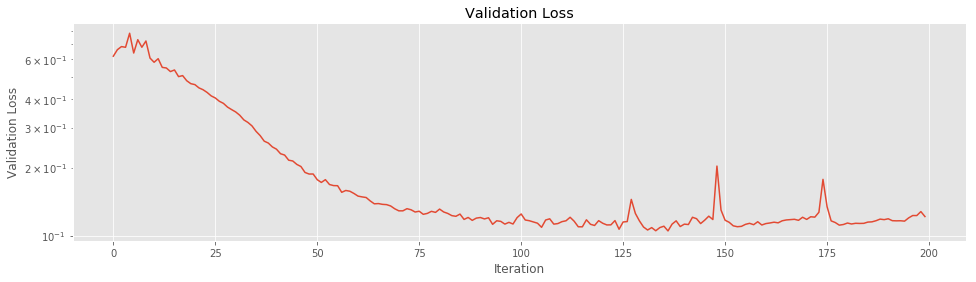

In [139]:
show_graph(history, 'val_loss', 'Validation Loss', 'Iteration', 'Validation Loss', 'log')

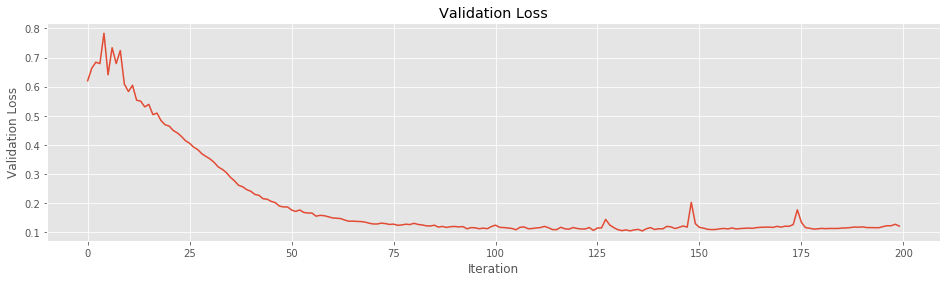

In [141]:
show_graph(history, 'val_loss', 'Validation Loss', 'Iteration', 'Validation Loss')

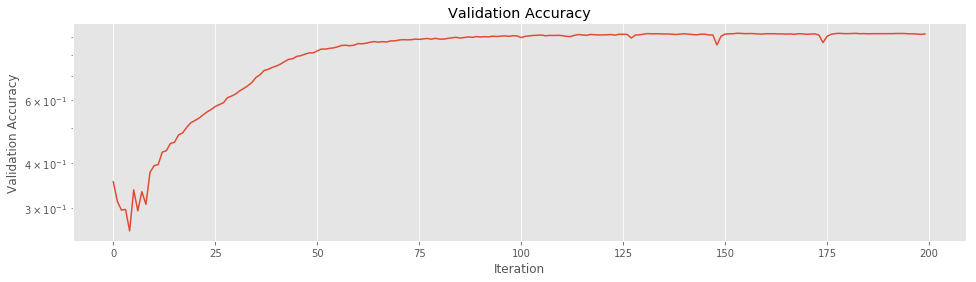

In [140]:
show_graph(history, 'val_acc', 'Validation Accuracy', 'Iteration', 'Validation Accuracy', 'log')

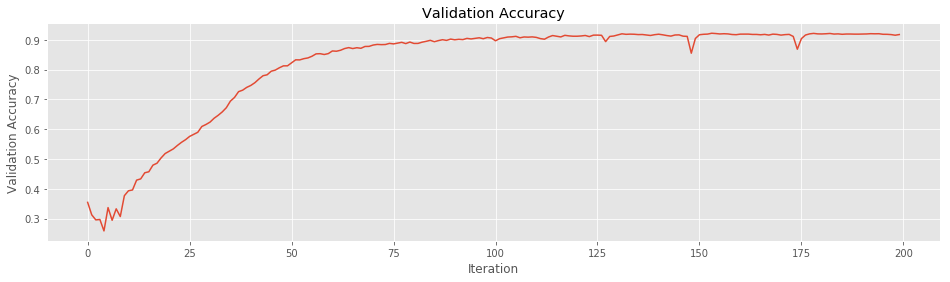

In [142]:
show_graph(history, 'val_acc', 'Validation Accuracy', 'Iteration', 'Validation Accuracy')